# Downloading essential libraries

In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data loading and preprocessing 

Dataset description :

Date: A unique identifier for each trading day. 
Close: Closing price of gold on the respective date. 
Volume: Gold trading volume on the corresponding date. 
Open: Opening price of gold on the respective date. 
High: The highest recorded price of gold during the trading day. 
Low: The lowest price recorded for gold in the trading day.

In [2]:
data = pd.read_csv('goldstock.csv', parse_dates=['Date'], index_col='Date')
data.head()

,Unnamed: 0,Close,Volume,Open,High,Low
Date,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1


In [3]:
data.describe()

,Unnamed: 0,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1260.792911,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,729.262879,298.824811,97600.769382,299.118187,301.262244,296.417703
min,0.000000,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,630.500000,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1259.000000,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1888.500000,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2532.000000,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2024-01-19 to 2014-01-22
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Close       2511 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2511 non-null   float64
 4   High        2511 non-null   float64
 5   Low         2511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 137.3 KB


In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

# Data visualization

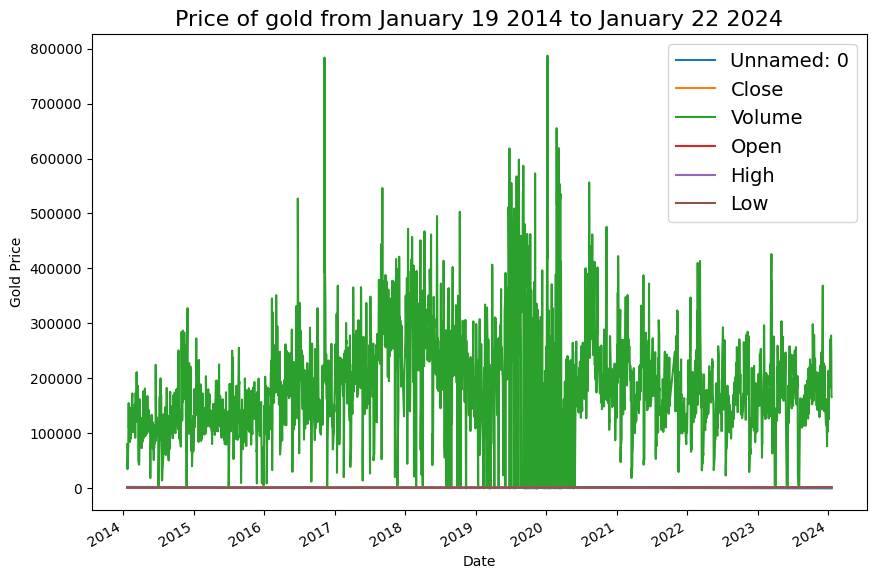

In [7]:
data.plot(figsize=(10, 7))
plt.ylabel("Gold Price")
plt.title("Price of gold from January 19 2014 to January 22 2024", fontsize=16)
plt.legend(fontsize=14)
plt.show()

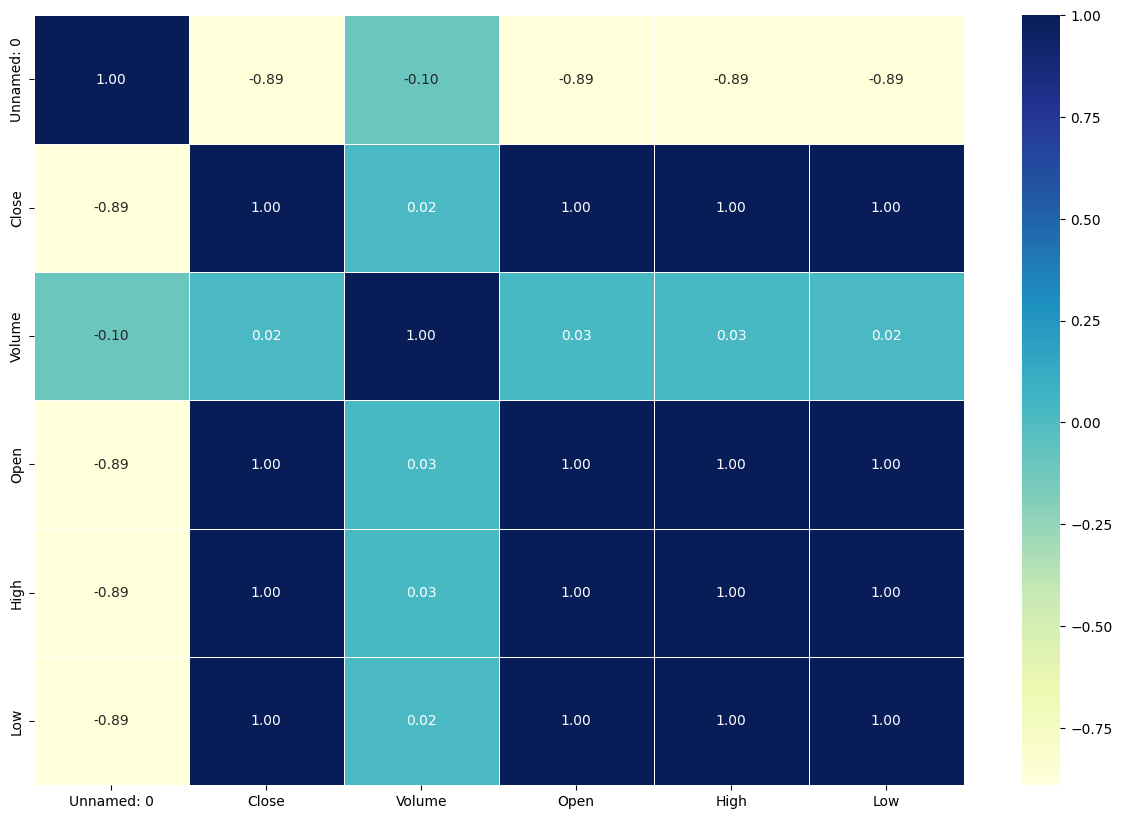

In [8]:
corr_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

# Creating train and test data 

In [9]:
def create_sequences(data, seq_length, horizon):
    x = []
    y = []
    for i in range(seq_length, len(data) - horizon + 1):
        x.append(data[i-seq_length:i])
        y.append(data[i:i+horizon])
    return np.array(x), np.array(y)


In [10]:
# Define window size (sequence length) and horizon (steps ahead)
seq_length = 60
horizon = 5  # Predicting 5 days ahead

In [11]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [12]:
# Create sequences
x_train, y_train = create_sequences(train_data, seq_length, horizon)
x_test, y_test = create_sequences(test_data, seq_length, horizon)

In [13]:
# Reshape y_train and y_test to be compatible with model output
y_train = y_train[:, -1, 0]  # Predict only the last value in the horizon
y_test = y_test[:, -1, 0]    # Predict only the last value in the horizon

In [27]:
x_train_ml = x_train.reshape(x_train.shape[0], -1)
x_test_ml = x_test.reshape(x_test.shape[0], -1)

In [14]:
y_train

array([0.84916148, 0.84781984, 0.85471969, ..., 0.05337805, 0.04475323,
       0.04657403])

In [15]:
y_test

array([0.12793483, 0.13215141, 0.1247724 , 0.11097269, 0.11011021,
       0.10186871, 0.09075228, 0.09496885, 0.09276473, 0.08433158,
       0.08337326, 0.06142789, 0.06286536, 0.07398179, 0.07867753,
       0.09199808, 0.09985625, 0.07848586, 0.07206517, 0.07973167,
       0.08452324, 0.06459032, 0.06650695, 0.05079061, 0.05567801,
       0.05146143, 0.05721131, 0.05021562, 0.06842357, 0.0688069 ,
       0.07177767, 0.08049832, 0.08643987, 0.07944418, 0.08088165,
       0.06995688, 0.0718735 , 0.0850024 , 0.09966459, 0.10541447,
       0.09928126, 0.07503594, 0.06449449, 0.06593196, 0.06046957,
       0.06324868, 0.07091519, 0.05567801, 0.05222808, 0.04264494,
       0.03881169, 0.03449928, 0.03938668, 0.03814087, 0.04360326,
       0.03747005, 0.04187829, 0.04513656, 0.04532822, 0.03440345,
       0.04264494, 0.04015333, 0.05165309, 0.05481552, 0.07886919,
       0.09036895, 0.09372305, 0.09956876, 0.10138955, 0.10378534,
       0.10503115, 0.10915189, 0.09870628, 0.11844753, 0.10915

In [16]:
x_test

array([[[0.05424054],
        [0.03785338],
        [0.03938668],
        ...,
        [0.11135601],
        [0.11173934],
        [0.10848107]],

       [[0.03785338],
        [0.03938668],
        [0.02299952],
        ...,
        [0.11173934],
        [0.10848107],
        [0.11164351]],

       [[0.03938668],
        [0.02299952],
        [0.03593675],
        ...,
        [0.10848107],
        [0.11164351],
        [0.11260182]],

       ...,

       [[0.23900335],
        [0.24072832],
        [0.23095352],
        ...,
        [0.19319598],
        [0.2015333 ],
        [0.1822712 ]],

       [[0.24072832],
        [0.23095352],
        [0.22520364],
        ...,
        [0.2015333 ],
        [0.1822712 ],
        [0.18485865]],

       [[0.23095352],
        [0.22520364],
        [0.22184954],
        ...,
        [0.1822712 ],
        [0.18485865],
        [0.20373742]]])

In [17]:
x_train

array([[[0.93885961],
        [0.93148059],
        [0.91701006],
        ...,
        [0.90828941],
        [0.90589363],
        [0.89746047]],

       [[0.93148059],
        [0.91701006],
        [0.93972209],
        ...,
        [0.90589363],
        [0.89746047],
        [0.8990896 ]],

       [[0.91701006],
        [0.93972209],
        [0.96023   ],
        ...,
        [0.89746047],
        [0.8990896 ],
        [0.90541447]],

       ...,

       [[0.18572113],
        [0.18265453],
        [0.17287973],
        ...,
        [0.08787734],
        [0.07436512],
        [0.07513177]],

       [[0.18265453],
        [0.17287973],
        [0.19233349],
        ...,
        [0.07436512],
        [0.07513177],
        [0.06401533]],

       [[0.17287973],
        [0.19233349],
        [0.19626258],
        ...,
        [0.07513177],
        [0.06401533],
        [0.06372784]]])

# Creating Models

In [18]:
# Model 1: Simple LSTM Model
def build_simple_lstm():
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
# Model 2: Bidirectional LSTM Model
def build_bidirectional_lstm():
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [20]:
# Model 3: LSTM with Dropout
def build_lstm_with_dropout():
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [21]:
# Train and evaluate each model
models = {
    'Simple LSTM': build_simple_lstm(),
    'Bidirectional LSTM': build_bidirectional_lstm(),
    'LSTM with Dropout': build_lstm_with_dropout()
}

history = {}
predictions = {}

In [22]:
for name, model in models.items():
    print(f"Training {name}...")
    hist = model.fit(x_train, y_train, batch_size=1, epochs=10, validation_split=0.2)
    history[name] = hist
    pred = model.predict(x_test)
    predictions[name] = scaler.inverse_transform(pred.reshape(-1, 1))

Training Simple LSTM...
Epoch 1/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.0131 - val_loss: 9.8676e-04
Epoch 2/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 3/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 0.0019 - val_loss: 8.0130e-04
Epoch 5/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.0019 - val_loss: 8.5326e-04
Epoch 6/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0015 - val_loss: 7.3374e-04
Epoch 7/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0016 - val_loss: 9.9774e-04
Epoch 8/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.0017 - val_loss: 7.4624e-04
Epoch 10/10
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.0016 - val_loss: 7.6766e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Trainin

In [28]:
# Train and evaluate each machine learning model
ml_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100),
    'Support Vector Regressor': SVR(kernel='rbf')
}

ml_predictions = {}

for name, model in ml_models.items():
    print(f"Training {name}...")
    model.fit(x_train_ml, y_train)
    pred = model.predict(x_test_ml)
    ml_predictions[name] = scaler.inverse_transform(pred.reshape(-1, 1))

Training Linear Regression...
Training Random Forest Regressor...
Training Support Vector Regressor...


In [38]:
# Combine predictions for visualization
predictions = {**predictions, **ml_predictions}

C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\1351252952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[name] = np.nan
C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\1351252952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[name] = np.nan
C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\1351252952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

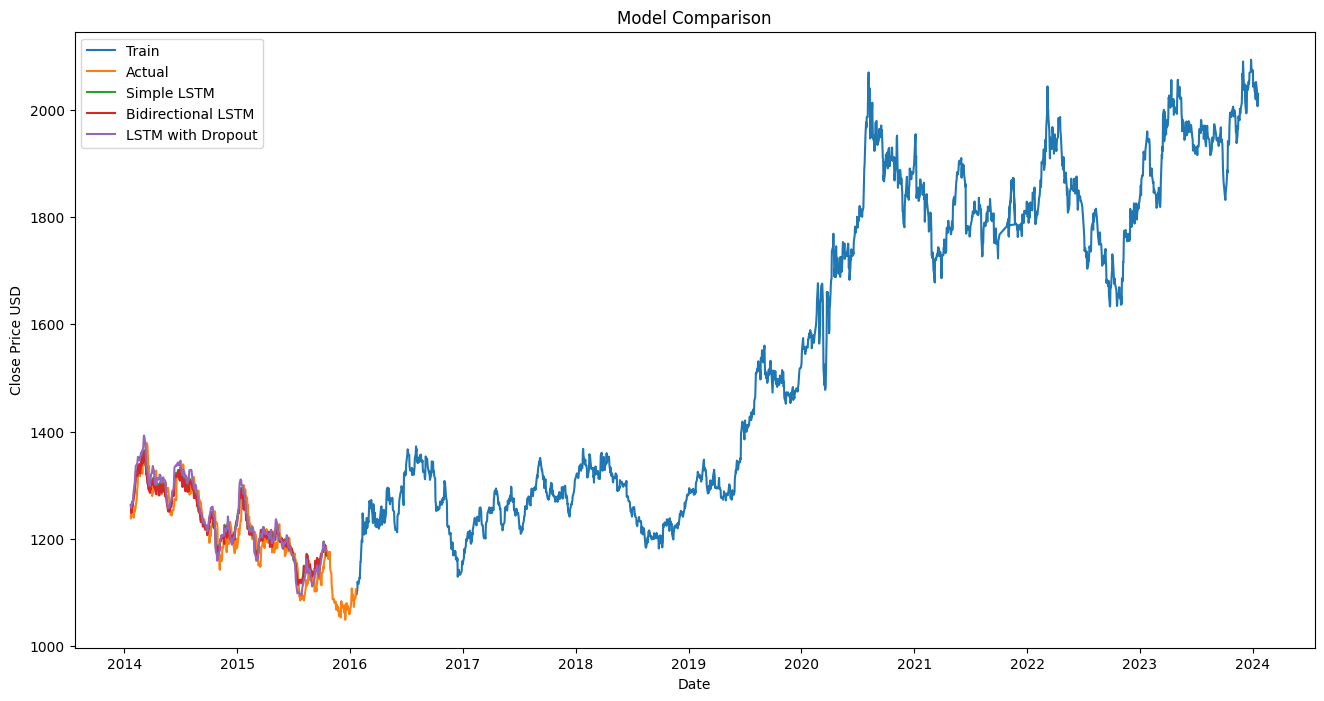

In [31]:
# Plot the results
train = data[:train_size]
valid = data[train_size:]
for name in predictions.keys():
    valid[name] = np.nan

for name in predictions.keys():
    valid.iloc[seq_length + horizon - 1:, valid.columns.get_loc(name)] = predictions[name]

# Visualize actual vs. predicted prices for each model
plt.figure(figsize=(16, 8))
plt.title('Model Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Actual')
for name in predictions.keys():
    plt.plot(valid[name], label=name)
plt.legend()
plt.show()

In [32]:
train = data[:train_size]
valid = data[train_size:]
valid['Simple LSTM'] = np.nan
valid['Bidirectional LSTM'] = np.nan
valid['LSTM with Dropout'] = np.nan

valid.iloc[seq_length + horizon - 1:, valid.columns.get_loc('Simple LSTM')] = predictions['Simple LSTM']
valid.iloc[seq_length + horizon - 1:, valid.columns.get_loc('Bidirectional LSTM')] = predictions['Bidirectional LSTM']
valid.iloc[seq_length + horizon - 1:, valid.columns.get_loc('LSTM with Dropout')] = predictions['LSTM with Dropout']

C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\176406758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Simple LSTM'] = np.nan
C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\176406758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Bidirectional LSTM'] = np.nan
C:\Users\hpenv\AppData\Local\Temp\ipykernel_22884\176406758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

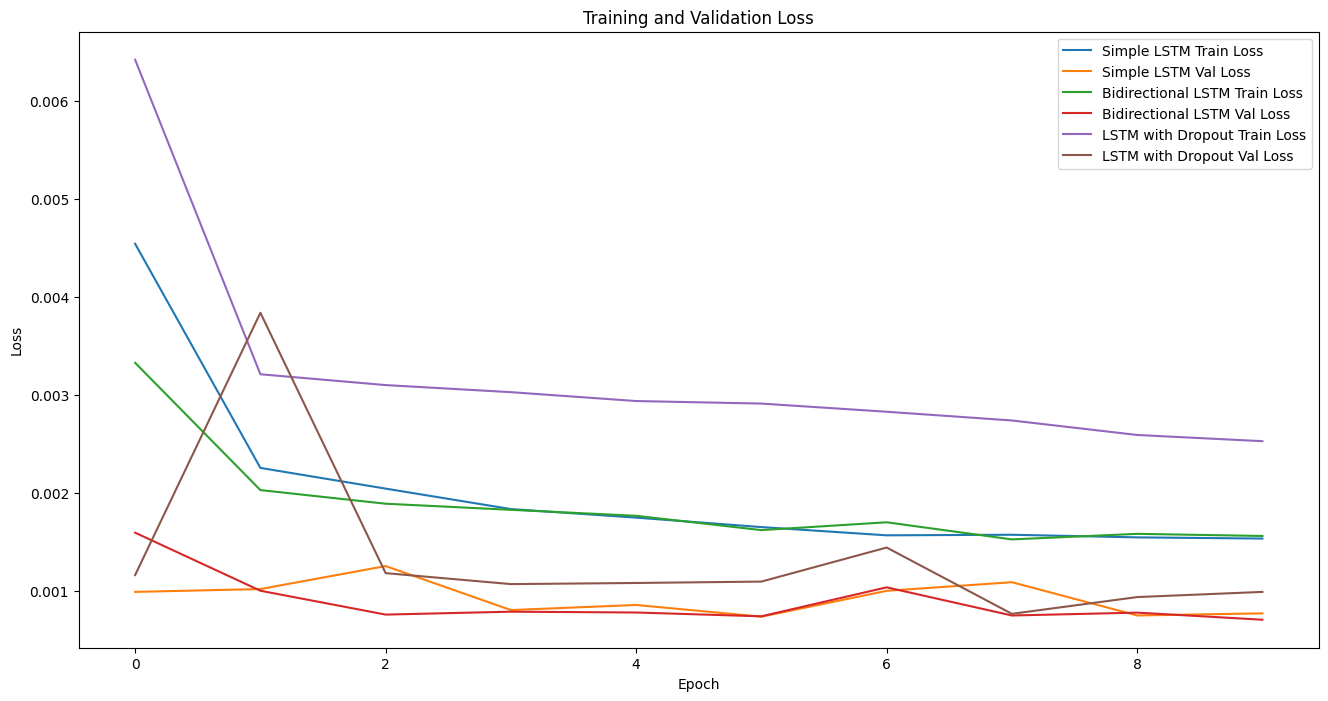

In [34]:
# Visualize training and validation loss over epochs
plt.figure(figsize=(16, 8))
for name, hist in history.items():
    plt.plot(hist.history['loss'], label=f'{name} Train Loss')
    plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Print the evaluation results
for name, loss in history.items():
    print(f"{name} Loss: {loss}")

Simple LSTM Loss: <keras.src.callbacks.history.History object at 0x000001ECA6806A40>
Bidirectional LSTM Loss: <keras.src.callbacks.history.History object at 0x000001ECA8DA5420>
LSTM with Dropout Loss: <keras.src.callbacks.history.History object at 0x000001ECB6B2A140>


In [36]:
# Use the last `seq_length` days to predict the next `horizon` days
last_sequence = scaled_data[-seq_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Next 5 days' predicted closing prices using Simple LSTM: [1250.7253 1255.1609 1261.7971 1268.0825 1272.4419]


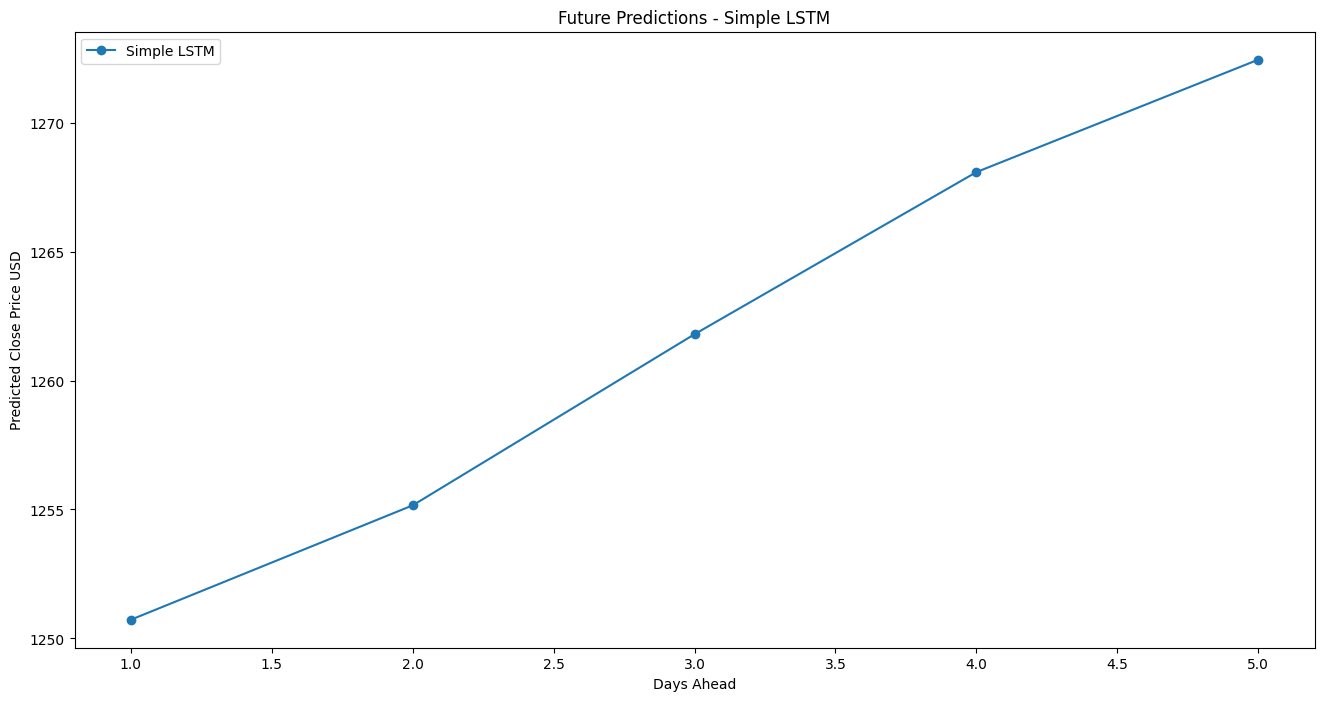

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Next 5 days' predicted closing prices using Bidirectional LSTM: [1244.7202 1249.5336 1256.6677 1261.9496 1263.748 ]


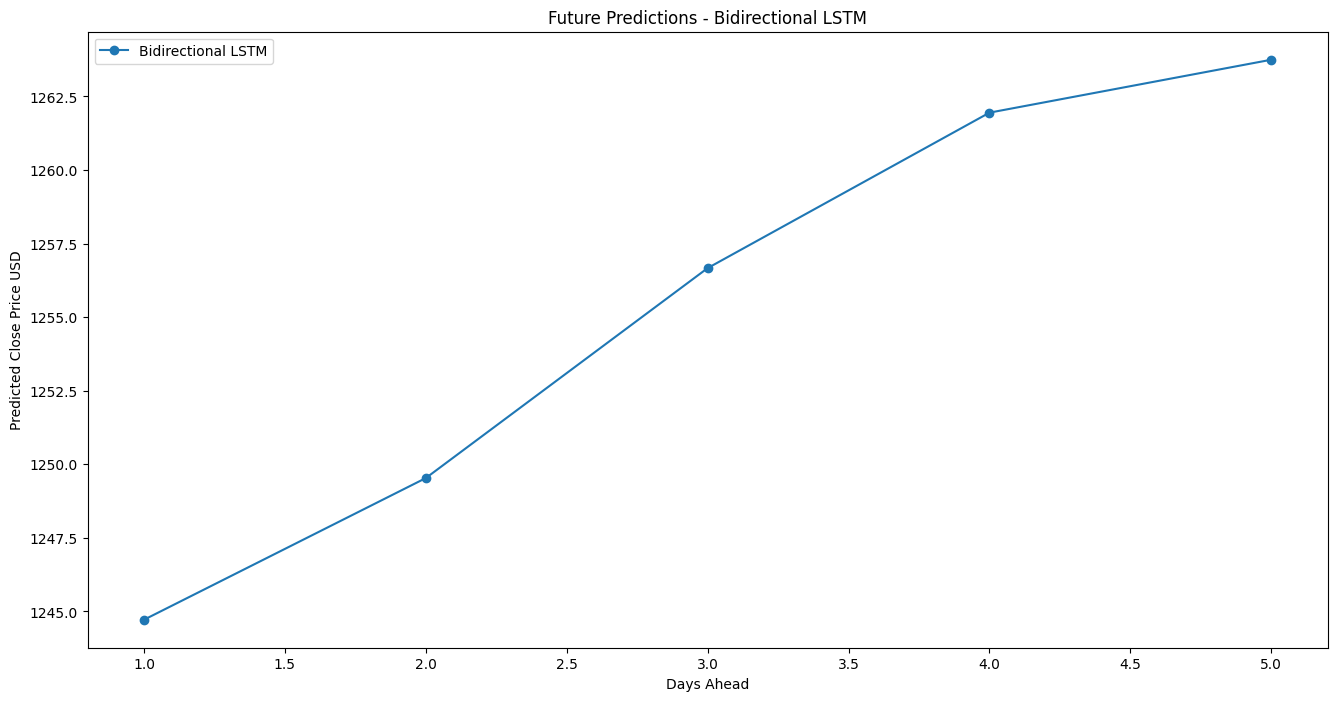

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Next 5 days' predicted closing prices using LSTM with Dropout: [1267.633  1271.3055 1277.5135 1284.5208 1291.9424]


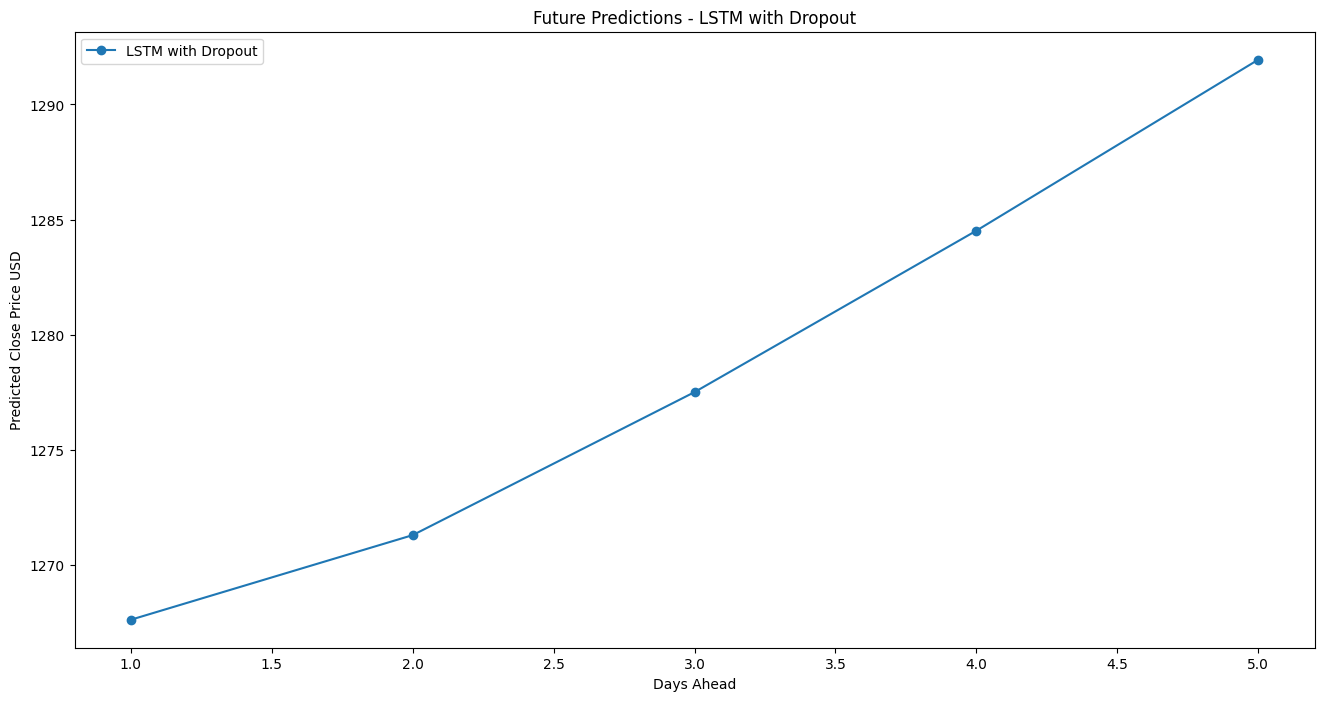

In [37]:
for name, model in models.items():
    future_predictions = []
    temp_sequence = last_sequence.copy()
    for _ in range(horizon):
        next_pred = model.predict(temp_sequence)
        future_predictions.append(next_pred[0, 0])
        next_pred = np.expand_dims(next_pred, axis=2)  # Reshape next_pred to (1, 1, 1)
        temp_sequence = np.append(temp_sequence[:, 1:, :], next_pred, axis=1)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    print(f"Next {horizon} days' predicted closing prices using {name}: {future_predictions.flatten()}")
    # Visualize future predictions
    plt.figure(figsize=(16, 8))
    plt.title(f'Future Predictions - {name}')
    plt.xlabel('Days Ahead')
    plt.ylabel('Predicted Close Price USD')
    plt.plot(range(1, horizon + 1), future_predictions.flatten(), marker='o', label=name)
    plt.legend()
    plt.show()

# Statistical informations

1.Descriptive Statistics:

Purpose: Descriptive statistics summarize and describe features of the dataset, providing initial insights into the characteristics of gold prices.
Examples: Mean, median, mode, standard deviation, range, skewness, and kurtosis of daily gold prices can highlight central tendency, variability, and distribution shape.

2.Time Series Analysis:

 Purpose: Analyze patterns, trends, and seasonal variations in gold prices over time.
 
 Methods:
 Trend Analysis: Identify long-term movements (increasing, decreasing, or stable trends) using techniques like linear regression or moving averages.
 Seasonality: Detect recurring patterns within specific time frames (e.g., daily, weekly, monthly) using seasonal decomposition methods or Fourier       transforms.
 Cyclicality: Explore periodic fluctuations that are not strictly seasonal, often associated with economic cycles or external factors.
 Stationarity: Test and ensure the time series properties remain consistent over time, essential for reliable modeling.

3.Correlation Analysis:

 Purpose: Examine relationships between gold prices and external factors or other financial metrics.
 
 Methods:
 Pearson Correlation: Measure linear correlation between gold prices and variables like inflation rates, currency values, or stock market indices.
 Spearman Rank Correlation: Assess monotonic relationships that may not be strictly linear.
 Cross-Correlation: Identify time lags or leads between gold prices and related variables, revealing potential causal relationships or dependencies.

4.Predictive Modeling Evaluation:

 Purpose: Assess the performance of predictive models in forecasting future gold prices.
 
 Methods:
 Mean Squared Error (MSE): Quantify the average squared difference between predicted and actual prices.
 Root Mean Squared Error (RMSE): Provide a measure of the model's prediction accuracy.
 Mean Absolute Error (MAE): Calculate the average absolute differences between predicted and actual prices, offering insights into model bias.
 R-squared (R²): Evaluate the proportion of the variance in gold prices explained by the model, indicating goodness of fit.
